<a href="https://colab.research.google.com/github/charurathour/Data-science-projects/blob/main/Retail_Transactions_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM-Based Customer Segmentation

In this notebook, we analyze customer purchasing behavior using the RFM (Recency, Frequency, Monetary) model. We calculate RFM metrics, assign scores (Low, Mid, High) based on value distribution, and segment customers accordingly. This helps identify high-value customers, loyal buyers, and potential churners, enabling better data-driven marketing strategies.

Importing data and doing basic exploration

In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ulrikthygepedersen/online-retail-dataset")

print("Path to dataset files:", path)

100%|██████████| 7.38M/7.38M [00:00<00:00, 84.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ulrikthygepedersen/online-retail-dataset/versions/2


In [46]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/ulrikthygepedersen/online-retail-dataset/versions/2"
print(os.listdir(dataset_path))

['online_retail.csv']


In [57]:
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import n_colors

In [47]:
df=pd.read_csv(dataset_path+"/online_retail.csv")

In [48]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [49]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [50]:
df.shape

(541909, 8)

In [51]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [52]:
df.dropna(subset=['CustomerID'],inplace=True)

In [53]:
df.shape

(406829, 8)

In [58]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [59]:
df['TotalAmount']=df['Quantity']*df['UnitPrice']

In [60]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [61]:
reference_date=max(df['InvoiceDate'])+dt.timedelta(days=1)

In [62]:
reference_date

Timestamp('2011-12-10 12:50:00')

In [63]:
rfm=df.groupby('CustomerID').agg({'InvoiceDate':lambda x:(reference_date-x.max()).days,
                                   'InvoiceNo':lambda x:len(x),
                                   'TotalAmount':lambda x:x.sum()})

In [65]:
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalAmount':'Monetary'},inplace=True)

In [66]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [68]:
quantiles=rfm.quantile(q=[0.25,0.5,0.75])

In [69]:
quantiles

,Recency,Frequency,Monetary
0.25,17.0,17.0,293.3625
0.50,50.0,42.0,648.0750
0.75,143.0,102.0,1611.7250


In [70]:
def Rscore(x,p,d):
    if p=='Recency':
        if x<=d[p][0.25]:
            return 4
        elif x<=d[p][0.5]:
            return 3
        elif x<=d[p][0.75]:
            return 2
        else:
            return 1
    else:
        if x<=d[p][0.25]:
            return 1
        elif x<=d[p][0.5]:
            return 2
        elif x<=d[p][0.75]:
            return 3
        else:
            return 4

In [71]:
rfm['R']=rfm['Recency'].apply(Rscore,args=('Recency',quantiles))
rfm['F']=rfm['Frequency'].apply(Rscore,args=('Frequency',quantiles))
rfm['M']=rfm['Monetary'].apply(Rscore,args=('Monetary',quantiles))

In [72]:
rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,13,176.60,4,1,1


In [73]:
rfm['rfm_Segment']=rfm['R'].astype(str)+rfm['F'].astype(str)+rfm['M'].astype(str)
rfm['rfm_Score']=rfm['R']+rfm['F']+rfm['M']

In [74]:
rfm

,Recency,Frequency,Monetary,R,F,M,rfm_Segment,rfm_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3
18281.0,181,7,80.82,1,1,1,111,3
18282.0,8,13,176.60,4,1,1,411,6


In [77]:
segment_labels=['Low Value','Mid-Value','High Value']
def assign_segment(score):
  if score <5:
    return 'Low Value'
  elif score <9:
    return 'Mid Value'
  else:
    return 'High Value'

rfm['Segment']=rfm['rfm_Score'].apply(assign_segment)

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

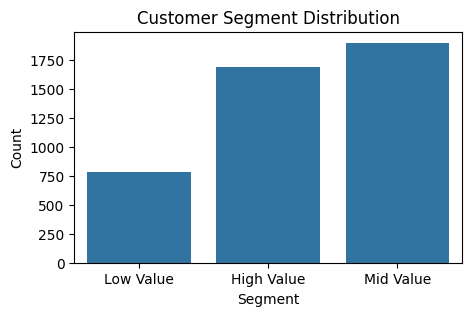

In [82]:
plt.figure(figsize=(5,3))
sns.countplot(x='Segment',data=rfm)
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()

Now according to segments assigned different customers can be targeted differently for marketing strategies and customer retention strategies